In [2]:
!pip install gensim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 67.7 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Loaded dataset: 5428 samples

=== TF-IDF + Logistic Regression ===
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       543
           1       0.94      0.92      0.93       543

    accuracy                           0.93      1086
   macro avg       0.93      0.93      0.93      1086
weighted avg       0.93      0.93      0.93      1086

AUC: 0.9818110286960444
Top indicative QAnon words: ['amp' 'tweet' '2018' 'storm' 'anon' 'conspiracy' 'awakening' 'red'
 'posts' 'post' 'cabal' 'maga' 'truth' 'msm' 'deep' 'potus' 'deep state'
 'wwg1wga' 'patriots' 'qanon']
Top indicative Non-QAnon words: ['removed' 'edit' 'bernie' 'sanders' 'nan trump' 'anarchist' 'capitalism'
 'socialist' 'bernie sanders' 'political' 'donald trump' 'party'
 'politics' 'year' 'college' 'climate' 'workers' 'anarchism' 'new year'
 'anarchists']

=== Word2Vec + XGBoost ===


Training Word2Vec: 100%|██████████| 4342/4342 [00:00<00:00, 5781.35it/s]
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [18:07:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.89      0.87      0.88       543
           1       0.87      0.89      0.88       543

    accuracy                           0.88      1086
   macro avg       0.88      0.88      0.88      1086
weighted avg       0.88      0.88      0.88      1086

AUC: 0.9599116836075416

=== Sentence-BERT + Logistic Regression ===


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/136 [00:00<?, ?it/s]

Batches:   0%|          | 0/34 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       543
           1       0.86      0.86      0.86       543

    accuracy                           0.86      1086
   macro avg       0.86      0.86      0.86      1086
weighted avg       0.86      0.86      0.86      1086

AUC: 0.9351905551655255

=== Overall Performance ===
                Model  Accuracy        F1       AUC
0         TF-IDF + LR  0.929098  0.928505  0.981811
1      Word2Vec + XGB  0.880295  0.881387  0.959912
2  Sentence-BERT + LR  0.859116  0.859504  0.935191


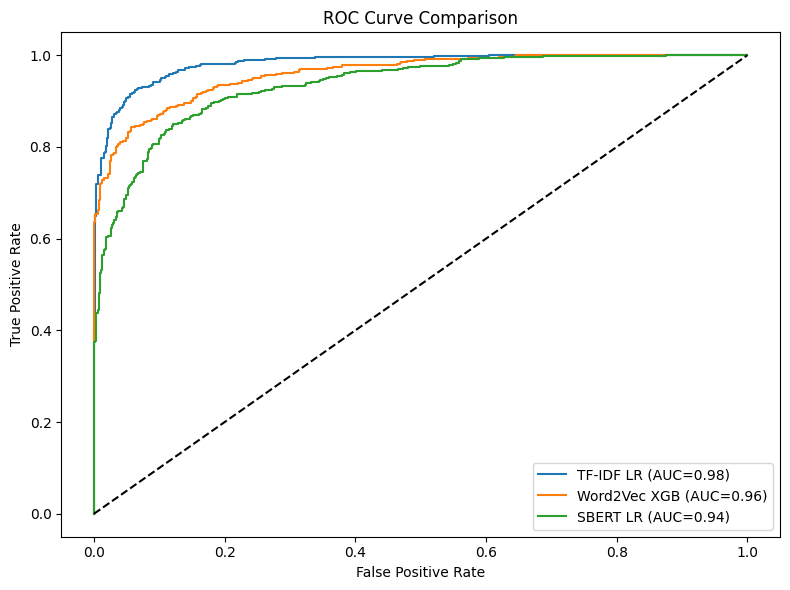


Example strong positive (QAnon) features:
cabal
maga
truth
msm
deep
potus
deep state
wwg1wga
patriots
qanon

Example strong negative (Non-QAnon) features:
removed
edit
bernie
sanders
nan trump
anarchist
capitalism
socialist
bernie sanders
political

Evaluation complete.


In [5]:
# ==============================================
# Model Evaluation Notebook (Optimized)
# Compares TF-IDF + Logistic Regression,
# Word2Vec + XGBoost, and Sentence-BERT models
# ==============================================

#for a faster runtime, execute on T4 GPU

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

from gensim.models import Word2Vec
from xgboost import XGBClassifier
from tqdm import tqdm

from sentence_transformers import SentenceTransformer
import torch

# 1. Load Data
data_path = "/content/drive/MyDrive/Final/data_inbetween/training_ready_balanced.csv"
df = pd.read_csv(data_path)
print(f"Loaded dataset: {df.shape[0]} samples")

X = df["text"].astype(str)
y = df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# =========================================================
# MODEL 1: TF-IDF + Logistic Regression
# =========================================================

print("\n=== TF-IDF + Logistic Regression ===")
tfidf_lr = Pipeline([
    ("tfidf", TfidfVectorizer(
        max_features=100000,
        ngram_range=(1,3),
        max_df=0.80,
        min_df=3,
        sublinear_tf=True,
        stop_words='english'
    )),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight='balanced',
        C=2.0,
        solver='liblinear',
        penalty='l2'
    ))
])
tfidf_lr.fit(X_train, y_train)
y_pred_lr = tfidf_lr.predict(X_test)
y_prob_lr = tfidf_lr.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred_lr))
print("AUC:", roc_auc_score(y_test, y_prob_lr))

feature_names = tfidf_lr.named_steps['tfidf'].get_feature_names_out()
coef = tfidf_lr.named_steps['clf'].coef_[0]
top_pos = np.argsort(coef)[-20:]
top_neg = np.argsort(coef)[:20]

print("Top indicative QAnon words:", feature_names[top_pos])
print("Top indicative Non-QAnon words:", feature_names[top_neg])


# =========================================================
# MODEL 2: Word2Vec + XGBoost
# =========================================================

print("\n=== Word2Vec + XGBoost ===")

def tokenize(text):
    return text.split()

sentences = [tokenize(t) for t in tqdm(X_train, desc="Training Word2Vec")]
w2v_model = Word2Vec(
    sentences,
    vector_size=200,
    window=7,
    min_count=2,
    workers=4,
    epochs=30,
    sg=1
)

def document_vector(doc):
    words = [w for w in doc if w in w2v_model.wv]
    if len(words) == 0:
        return np.zeros(200)
    return np.mean(w2v_model.wv[words], axis=0)

X_train_vec = np.array([document_vector(tokenize(t)) for t in X_train])
X_test_vec = np.array([document_vector(tokenize(t)) for t in X_test])

xgb = XGBClassifier(
    n_estimators=2000,
    learning_rate=0.03,
    max_depth=9,
    subsample=0.85,
    colsample_bytree=0.85,
    reg_alpha=0.10,
    reg_lambda=2.0,
    gamma=1.0,
    scale_pos_weight=1,
    use_label_encoder=False,
    eval_metric='logloss'
)
xgb.fit(X_train_vec, y_train)
y_pred_xgb = xgb.predict(X_test_vec)
y_prob_xgb = xgb.predict_proba(X_test_vec)[:, 1]

print(classification_report(y_test, y_pred_xgb))
print("AUC:", roc_auc_score(y_test, y_prob_xgb))


# =========================================================
# MODEL 3: Sentence-BERT + Logistic Regression
# =========================================================

print("\n=== Sentence-BERT + Logistic Regression ===")

sbert_model = SentenceTransformer('all-mpnet-base-v2')
X_train_emb = sbert_model.encode(X_train.tolist(), show_progress_bar=True, convert_to_numpy=True)
X_test_emb = sbert_model.encode(X_test.tolist(), show_progress_bar=True, convert_to_numpy=True)

sbert_clf = LogisticRegression(
    max_iter=1000,
    class_weight='balanced',
    C=0.7,
    solver='saga',
    penalty='l2'
)

sbert_clf.fit(X_train_emb, y_train)
y_pred_sbert = sbert_clf.predict(X_test_emb)
y_prob_sbert = sbert_clf.predict_proba(X_test_emb)[:, 1]

print(classification_report(y_test, y_pred_sbert))
print("AUC:", roc_auc_score(y_test, y_prob_sbert))

# =========================================================
# COMPARISON SUMMARY
# =========================================================

results = pd.DataFrame({
    'Model': ['TF-IDF + LR', 'Word2Vec + XGB', 'Sentence-BERT + LR'],
    'Accuracy': [accuracy_score(y_test, y_pred_lr), accuracy_score(y_test, y_pred_xgb), accuracy_score(y_test, y_pred_sbert)],
    'F1': [f1_score(y_test, y_pred_lr), f1_score(y_test, y_pred_xgb), f1_score(y_test, y_pred_sbert)],
    'AUC': [roc_auc_score(y_test, y_prob_lr), roc_auc_score(y_test, y_prob_xgb), roc_auc_score(y_test, y_prob_sbert)]
})

print("\n=== Overall Performance ===")
print(results)

# =========================================================
# ROC Curves
# =========================================================

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_sbert, tpr_sbert, _ = roc_curve(y_test, y_prob_sbert)

plt.figure(figsize=(8,6))
plt.plot(fpr_lr, tpr_lr, label=f'TF-IDF LR (AUC={roc_auc_score(y_test, y_prob_lr):.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'Word2Vec XGB (AUC={roc_auc_score(y_test, y_prob_xgb):.2f})')
plt.plot(fpr_sbert, tpr_sbert, label=f'SBERT LR (AUC={roc_auc_score(y_test, y_prob_sbert):.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.tight_layout()
plt.show()

# =========================================================
# Optional: Attention / Feature Examples
# =========================================================

# For interpretability, show top attention-like indicators from TF-IDF model
print("\nExample strong positive (QAnon) features:")
for term in feature_names[top_pos][-10:]:
    print(term)

print("\nExample strong negative (Non-QAnon) features:")
for term in feature_names[top_neg][:10]:
    print(term)

print("\nEvaluation complete.")



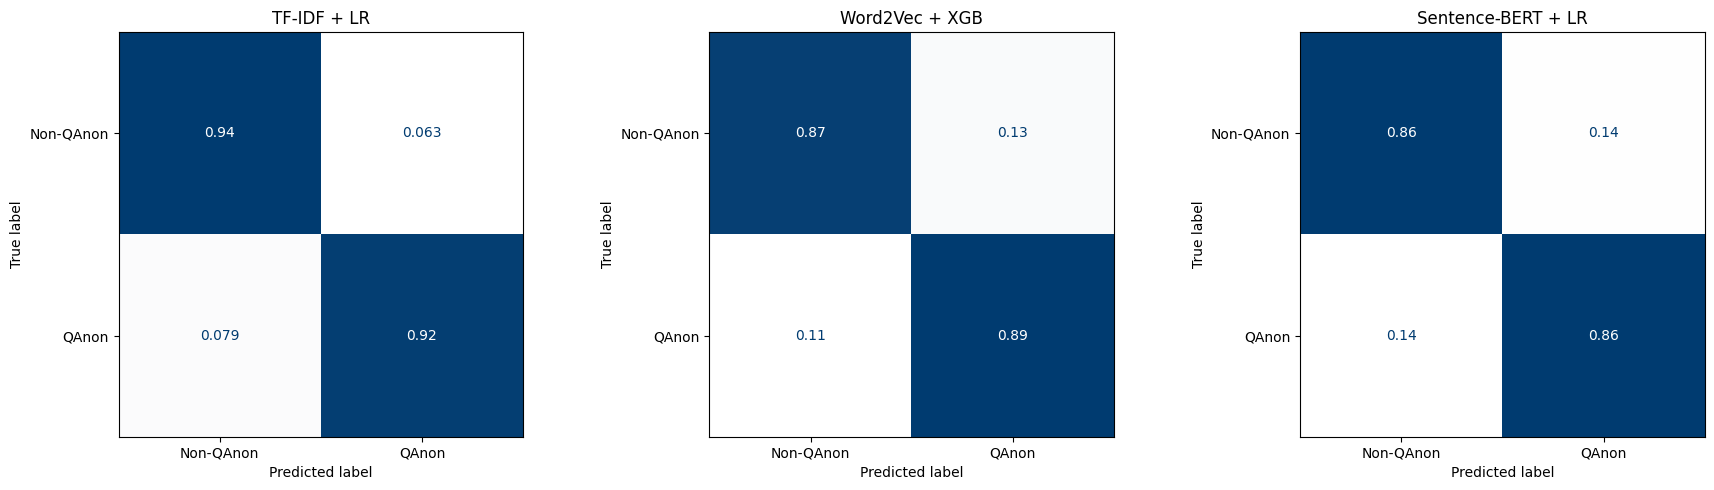

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib.colors import LinearSegmentedColormap

# Create custom colormap: white → University of Iceland blue
ui_blue = "#003B70"
custom_cmap = LinearSegmentedColormap.from_list("white_to_ui_blue", ["white", ui_blue])

fig, axes = plt.subplots(1, 3, figsize=(18,5))

models = [
    ('TF-IDF + LR', y_pred_lr),
    ('Word2Vec + XGB', y_pred_xgb),
    ('Sentence-BERT + LR', y_pred_sbert)
]

for idx, (name, y_pred) in enumerate(models):
    cm = confusion_matrix(y_test, y_pred, normalize="true")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-QAnon", "QAnon"])
    disp.plot(ax=axes[idx], colorbar=False, cmap=custom_cmap)
    axes[idx].set_title(name)

plt.tight_layout()
plt.show()